In [1]:
import time

from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
import pickle
import pandas as pd

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [2]:
## Load models
bi_encoder = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
"""
How to encode the corpus embeddings???
bi_encoder? check that the output looks like the pickled objects below...
"""
corpus_embeddings = pd.read_pickle("corpus_embeddings_cpu.pkl")
corpus = pd.read_pickle("corpus.pkl")

In [107]:
df = pd.read_csv('debates_by_message.csv', low_memory=False)

In [109]:
df.head()

,date,block,speaker,message
0,2020-12-01,0,SPEAKER,No select committee reports have been delivere...
1,2020-12-01,0,CLERK,Petition of Sophie Handford requesting that th...
2,2020-12-01,0,SPEAKER,That petition stands referred to the Petitions...
3,2020-12-01,0,CLERK,Report in relation to selected non-departmenta...
4,2020-12-01,0,SPEAKER,Those papers are published under the authority...


In [150]:
for n in [100, 1000, 2000, 5000]:
    t0 = time.time()
    parliament_embeddings = bi_encoder.encode(df['message'][:n], convert_to_tensor=True)
    t = time.time() - t0
    print(f'For n = {n} - {t:.2f} seconds')

For n = 100 - 2.22 seconds
For n = 1000 - 24.45 seconds
For n = 2000 - 50.76 seconds
For n = 5000 - 130.02 seconds


In [112]:
# parliament_embeddings.shape

torch.Size([100, 384])

In [161]:
corpus_embeddings = parliament_embeddings
corpus = df['message'].fillna('').tolist()[:n]
# print(corpus_embeddings.shape, len(corpus))

torch.Size([5000, 384]) 5000


In [190]:
query = 'crypto currency'
top_k = 100

question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
hits = hits[0]  # Get the hits for the first query

# hits[:5]

In [191]:
# cross_inp[-5:]

In [192]:
##### Re-Ranking #####
# Now, score all retrieved passages with the cross_encoder
cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
cross_scores = cross_encoder.predict(cross_inp)
# cross_scores[:5]

In [193]:
# Sort results by the cross-encoder scores
for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]

hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)

ans = []
for idx, hit in enumerate(hits[0:5]):
    ci = hit['corpus_id']
    ans.append(corpus[ci])
#     print(f"\nOn {df['date'][ci]}:\n{df['speaker'][ci]}:\n{corpus[ci]}")

In [166]:
# corpus[:5]

In [194]:
# hits[:5]

In [169]:
df['speaker'].value_counts()[:10]

SPEAKER                                      5213
Rt Hon JACINDA ARDERN                        2001
Hon GRANT ROBERTSON                          1973
DEPUTY SPEAKER                               1647
Hon CHRIS HIPKINS                            1412
DAVID SEYMOUR (Leader—ACT)                   1280
CHAIRPERSON (Hon Jenny Salesa)               1228
CHAIRPERSON (Hon Jacqui Dean)                1195
Hon GRANT ROBERTSON (Minister of Finance)    1155
Hon ANDREW LITTLE                            1054
Name: speaker, dtype: int64

In [173]:
parliament_embeddings[[0, 3], :].shape

torch.Size([2, 384])

In [189]:
# Choose who said it
speaker = None
# speaker = 'SPEAKER'
# speaker = 'Rt Hon JACINDA ARDERN'
# speaker = 'Hon GRANT ROBERTSON'
# speaker = 'DEPUTY SPEAKER'
# speaker = 'Hon CHRIS HIPKINS'
# speaker = 'DAVID SEYMOUR (Leader—ACT)'
# speaker = 'Hon ANDREW LITTLE'


if speaker is not None:
    print(f'Getting closest statements from: {speaker}')
    sub_df = df.iloc[:n, :].loc[ df['speaker'] == speaker ].copy()
    corpus_embeddings = parliament_embeddings[sub_df.index, :]
    corpus = sub_df['message'].fillna('').tolist()
else:
    print('Getting closest statements from any person')
    sub_df = df.iloc[:n, :].copy()
    corpus_embeddings = parliament_embeddings
    corpus = sub_df['message'].fillna('').tolist() 
print(corpus_embeddings.shape, len(corpus))

query = 'house prices for first home buyers'
query = 'rising interest rates'
query = 'reducing crime'
top_k = 100

question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
hits = hits[0]  # Get the hits for the first query

# score all retrieved passages with the cross_encoder
cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
cross_scores = cross_encoder.predict(cross_inp)
# cross_scores[:5]

# Sort results by the cross-encoder scores
for idx in range(len(cross_scores)):
    hits[idx]['cross-score'] = cross_scores[idx]

hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)

ans = []
sub_df = sub_df.reset_index(drop=True)
for idx, hit in enumerate(hits[0:5]):
    ci = hit['corpus_id']
    ans.append(corpus[ci])
    print(f"\nOn {sub_df['date'][ci]}:\n{sub_df['speaker'][ci]}:\n{corpus[ci]}")

Getting closest statements from any person
torch.Size([5000, 384]) 5000

On 2020-07-30:
Hon AMY ADAMS:
In my three years as justice Minister, it very quickly became clear to me that the best thing we could do to reduce crime was to intervene many, many years before the offenders ever turn up in court. That was the basis of my absolute adoption of the importance of social investment as championed by Sir Bill English. Yes, it's early intervention, but it's so much more and involves radical change to our delivery models if we're going to make progress on the hard intergenerational issues. Last week in her valedictory, the Hon Anne Tolley talked about the work that she and I had led to change the delivery model for family violence and to force agencies to come together to treat it as everyone's problem, not just something for the police. The integrated safety response pilots we set up in Christchurch and the Waikato are embodiments of that, and hearing from those involved that many lives h

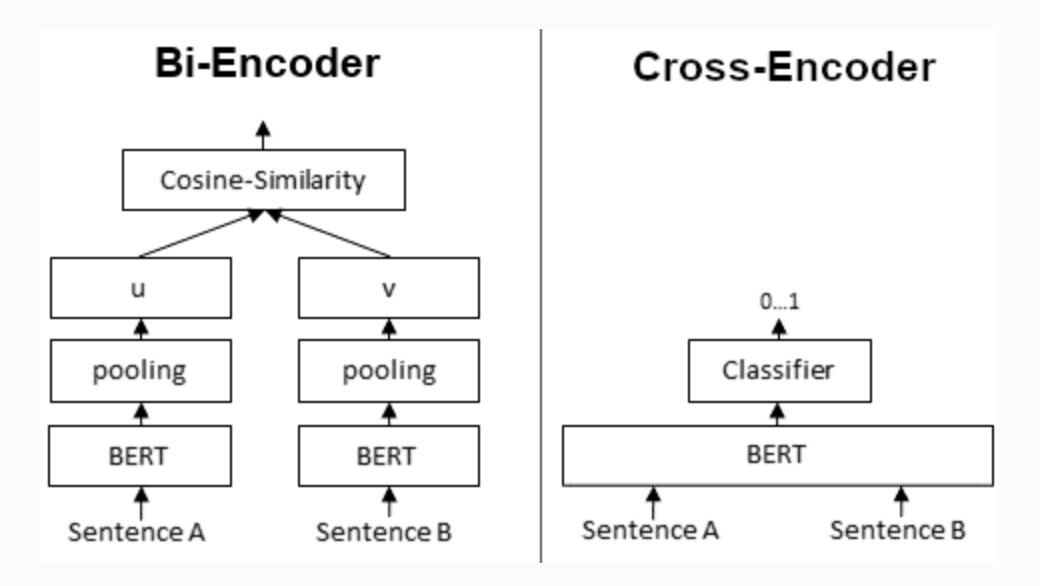

In [ ]:
def search(query, top_k=100):
    print("Top 5 Answer by the NSE:")
    print()
    ans=[]
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    
    for idx, hit in enumerate(hits[0:5]):
        ans.append(corpus[hit['corpus_id']])
    return ans[0],ans[1],ans[2],ans[3],ans[4]

exp=["Who is steve jobs?","What is coldplay?","What is a turing test?","What is the most interesting thing about our universe?","What are the most beautiful places on earth?"]

desc="This is a semantic search engine powered by SentenceTransformers (Nils_Reimers) with a retrieval and reranking system on Wikipedia corous. This will return the top 5 results. So Quest on with Transformers."

inp=gr.inputs.Textbox(lines=1, placeholder=None, default="", label="search you query here")
out=gr.outputs.Textbox(type="auto",label="search results")

iface = gr.Interface(fn=search, inputs=inp, outputs=[out,out,out,out,out],examples=exp,article=desc,title="Neural Search Engine",theme="huggingface",layout='vertical')
iface.launch()